In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
df_2019 = pd.read_csv('data_for_wr2019.csv')

Проверка на дубликат

In [4]:
df_2019.duplicated().sum()

np.int64(0)

In [124]:
df_2019 = df_2019.drop("Unnamed: 0", axis=1)

In [137]:
columns_for_under_zero = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount',
       'total_amount', 'cluster']
for column in columns_for_under_zero:
    was_lines = len(df_2019)
    print("Убрано отрицательных строк у колонки",column , " : ", was_lines - len(df_2019.where(df_2019[column] > 0).dropna().reset_index().drop("index", axis=1)))

Убрано отрицательных строк у колонки trip_distance  :  0
Убрано отрицательных строк у колонки fare_amount  :  0
Убрано отрицательных строк у колонки extra  :  0
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки tolls_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  0
Убрано отрицательных строк у колонки cluster  :  0


Делаем функцию для уменьшения данных в два раза с сохранением пропорций данных с изначальными 

In [44]:
def work_with_proportion(df, year):
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], format="%m/%d/%Y %I:%M:%S %p")
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], format="%m/%d/%Y %I:%M:%S %p")

    df = df[df["tpep_dropoff_datetime"].apply(lambda x: x.year) == year]

    month_year = df.tpep_dropoff_datetime.apply(lambda x: x.month).unique()
    count_in_month = [df[df.tpep_dropoff_datetime.apply(lambda x: x.month) == month]["VendorID"].count() for month in month_year]
    count_in_month = list(map(lambda x: x//2 ,count_in_month))
    return pd.concat([df[df.tpep_dropoff_datetime.apply(lambda x: x.month) == month].head(count) for month, count in zip(month_year, count_in_month)]).reset_index(drop=True) 

Применяем функцию

In [125]:
df_2019 = work_with_proportion(df_2019, 2019)


In [47]:
df_2019.isna().sum().sum()


np.int64(0)

В таблице нет пустых значений

In [42]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999962 entries, 0 to 1999961
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   VendorID               int64         
 2   tpep_pickup_datetime   datetime64[ns]
 3   tpep_dropoff_datetime  datetime64[ns]
 4   passenger_count        int64         
 5   trip_distance          float64       
 6   RatecodeID             int64         
 7   store_and_fwd_flag     object        
 8   PULocationID           int64         
 9   DOLocationID           int64         
 10  payment_type           int64         
 11  fare_amount            float64       
 12  extra                  float64       
 13  mta_tax                float64       
 14  tip_amount             float64       
 15  tolls_amount           float64       
 16  improvement_surcharge  float64       
 17  total_amount           float64       
 18  congestion_surcharge  

Кластеризация

Сделаем дату числовым значением для кластеризации

In [126]:
df_2019["time_trip"] = (df_2019["tpep_dropoff_datetime"] - df_2019["tpep_pickup_datetime"]).apply(lambda x: x.total_seconds())

In [127]:
df_2019 = df_2019.drop(["tpep_dropoff_datetime","tpep_pickup_datetime"], axis=1)

In [54]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999962 entries, 0 to 1999961
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   VendorID               int64  
 2   passenger_count        int64  
 3   trip_distance          float64
 4   RatecodeID             int64  
 5   store_and_fwd_flag     object 
 6   PULocationID           int64  
 7   DOLocationID           int64  
 8   payment_type           int64  
 9   fare_amount            float64
 10  extra                  float64
 11  mta_tax                float64
 12  tip_amount             float64
 13  tolls_amount           float64
 14  improvement_surcharge  float64
 15  total_amount           float64
 16  congestion_surcharge   float64
 17  time_trip              float64
dtypes: float64(10), int64(7), object(1)
memory usage: 274.7+ MB


У нас остался объект, который нельзя масштабировать это "store_and_fwd_flag" - у него два значения, предлагаю удалить, потому что описание его в интернете "Этот флаг указывает, сохранялась ли запись о поездке в автомобиле. памяти перед отправкой продавцу, он же «хранить и пересылать», потому что у автомобиля не было соединения с сервером"

Думаю это не важный параметр

In [128]:
df_2019 = df_2019.drop("store_and_fwd_flag",axis=1)

Переходим к масштабированию и нормализации

In [48]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [195]:
scal = StandardScaler()
norm = Normalizer()
df_for_pca_2019 = pd.DataFrame(norm.fit_transform(scal.fit_transform(df_2019)), columns=df_2019.columns, index=df_2019.index)

In [58]:
from sklearn.decomposition import PCA

In [196]:
pca = PCA(n_components=2)
for_cluster_2019 = pca.fit_transform(df_for_pca_2019)

In [61]:
from sklearn.cluster import KMeans

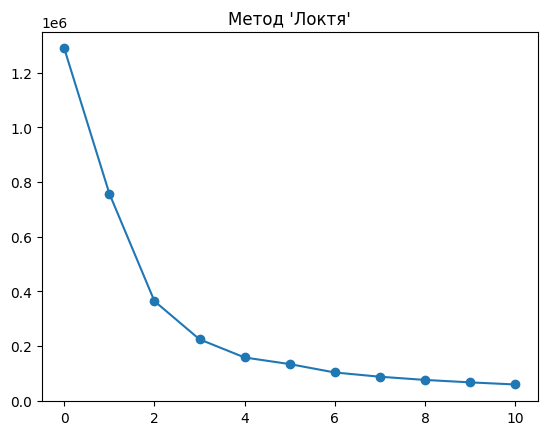

In [197]:
list_for_elbow = []
for n_clusters in range(1,12):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++')
    kmeans.fit(for_cluster_2019)
    list_for_elbow.append(kmeans.inertia_)
plt.title("Метод 'Локтя'")
plt.plot(list_for_elbow, marker='o')

In [198]:
n_cluster = 4

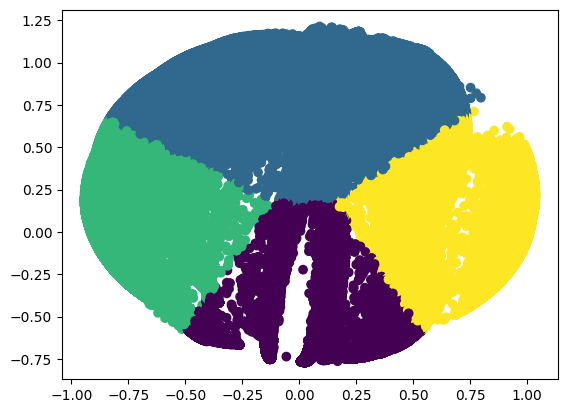

In [199]:
kmean = KMeans(n_clusters=n_cluster)
kmean.fit(for_cluster_2019)
labels = kmean.labels_
plt.scatter(for_cluster_2019[:, 0], for_cluster_2019[:, 1], c=labels, cmap='viridis')

In [201]:
df_2019["cluster"] = labels

In [205]:
def info_clusters(df):
    for cluster in range(n_cluster):
        print("Кластер ",cluster)
        for column in df.columns:
            if column == "cluster":
                continue
            print(column," max: ", round(df[column].where(df["cluster"] == cluster).dropna().max(),2), " min: ", round(df[column].where(df["cluster"] == cluster).dropna().min(),2),
                  " mean: ", round(df[column].where(df["cluster"] == cluster).dropna().mean(),2))

In [206]:
info_clusters(df_2019)

Кластер  0
trip_distance  max:  17.5  min:  0.0  mean:  1.75
fare_amount  max:  30.56  min:  0.0  mean:  9.64
extra  max:  2.5  min:  0.0  mean:  0.25
tip_amount  max:  12.0  min:  0.0  mean:  1.68
tolls_amount  max:  14.75  min:  0.0  mean:  0.0
total_amount  max:  31.1  min:  0.0  mean:  14.53
time_trip  max:  57287.0  min:  0.0  mean:  711.42
Кластер  1
trip_distance  max:  157.8  min:  0.0  mean:  8.01
fare_amount  max:  756.0  min:  0.0  mean:  29.97
extra  max:  9.5  min:  0.0  mean:  1.04
tip_amount  max:  400.0  min:  0.0  mean:  5.14
tolls_amount  max:  607.74  min:  0.0  mean:  1.74
total_amount  max:  766.8  min:  0.0  mean:  40.12
time_trip  max:  86392.0  min:  0.0  mean:  2970.59
Кластер  2
trip_distance  max:  15.4  min:  0.0  mean:  1.37
fare_amount  max:  28.2  min:  0.0  mean:  8.12
extra  max:  1.0  min:  0.0  mean:  0.25
tip_amount  max:  10.0  min:  0.0  mean:  1.31
tolls_amount  max:  6.12  min:  0.0  mean:  0.0
total_amount  max:  29.0  min:  0.3  mean:  12.91
ti

Предложение, убираем колонки которые не изменяются и анализируем значения 

Колонки, которые, почти, не изменяются из кластер в кластер: VendorID, passenger_count, PULocationID, DOLocationID, mta_tax, congestion_surcharge, payment_type, RatecodeID, improvement_surcharge

tolls_amount - в трех кластерах нулевое значение

In [207]:
columns_for_drop = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "mta_tax", "congestion_surcharge", "payment_type", "RatecodeID", "improvement_surcharge","tolls_amount"]

In [108]:
info_clusters(df_2019.drop(columns_for_drop, axis=1))

Кластер  0
trip_distance  max:  157.8  min:  0.0
fare_amount  max:  756.0  min:  -52.0
extra  max:  4.5  min:  -4.5
tip_amount  max:  400.0  min:  -8.0
tolls_amount  max:  607.74  min:  -2.8
total_amount  max:  766.8  min:  -59.8
time_trip  max:  86392.0  min:  -3472.0
Кластер  1
trip_distance  max:  19.5  min:  0.0
fare_amount  max:  52.0  min:  0.0
extra  max:  5.5  min:  0.0
tip_amount  max:  12.22  min:  0.0
tolls_amount  max:  12.5  min:  0.0
total_amount  max:  55.3  min:  1.3
time_trip  max:  8495.0  min:  -3469.0
Кластер  2
trip_distance  max:  33.03  min:  0.0
fare_amount  max:  35.0  min:  -156.0
extra  max:  3.5  min:  -5.0
tip_amount  max:  16.78  min:  -39.25
tolls_amount  max:  12.8  min:  -22.5
total_amount  max:  38.8  min:  -176.89
time_trip  max:  86321.0  min:  -3520.0
Кластер  3
trip_distance  max:  49.4  min:  0.0
fare_amount  max:  198.5  min:  0.0
extra  max:  87.56  min:  0.0
tip_amount  max:  45.0  min:  0.0
tolls_amount  max:  31.12  min:  0.0
total_amount  ma

 Для точного анализва удалим отрицательные значение, там шде они не должны быть, а именно во времени поездки и разного рода колонок связаного с деньгами

In [158]:
columns_for_under_zero = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount',
       'total_amount', 'time_trip']
for column in columns_for_under_zero:
    was_lines = len(df_2019)
    df_2019 = df_2019[df_2019[column] >= 0]
    print("Убрано отрицательных строк у колонки",column , " : ", was_lines - len(df_2019))

Убрано отрицательных строк у колонки trip_distance  :  0
Убрано отрицательных строк у колонки fare_amount  :  5340
Убрано отрицательных строк у колонки extra  :  2
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки tolls_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  0
Убрано отрицательных строк у колонки time_trip  :  972


Функция для обновления данных

In [166]:
def full_update_df(df, year):
    df = df.drop("Unnamed: 0", axis=1)
    df = work_with_proportion(df, year)
    df["time_trip"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).apply(lambda x: x.total_seconds())
    df = df.drop(["tpep_dropoff_datetime","tpep_pickup_datetime"], axis=1)
    df = df.drop("store_and_fwd_flag",axis=1)
    
    columns_for_drop = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "mta_tax", "congestion_surcharge", "payment_type", "RatecodeID", "improvement_surcharge","tolls_amount"]
    df = df.drop(columns_for_drop, axis=1)
    
    columns_for_under_zero = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount',
       'total_amount', 'time_trip']
    for column in columns_for_under_zero:
        was_lines = len(df)
        df = df[df[column] >= 0]
        print("Убрано отрицательных строк у колонки",column , " : ", was_lines - len(df))
    return df

In [155]:
df_2019 = full_update_df(df_2019, 2019)

In [167]:
df_2020 = full_update_df(pd.read_csv("data_for_wr2020.csv"), 2020)

Убрано отрицательных строк у колонки trip_distance  :  13
Убрано отрицательных строк у колонки fare_amount  :  6309
Убрано отрицательных строк у колонки extra  :  0
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки tolls_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  2
Убрано отрицательных строк у колонки time_trip  :  1


In [168]:
df_2021 = full_update_df(pd.read_csv("data_for_wr2021.csv"), 2021)

/var/folders/gl/gpj9t_b5575czff753kz6yb40000gn/T/ipykernel_73133/1431357260.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2021 = full_update_df(pd.read_csv("data_for_wr2021.csv"), 2021)


Убрано отрицательных строк у колонки trip_distance  :  0
Убрано отрицательных строк у колонки fare_amount  :  9926
Убрано отрицательных строк у колонки extra  :  0
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки tolls_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  0
Убрано отрицательных строк у колонки time_trip  :  1


Рассмотрим плотность распределения

In [216]:
from scipy.stats import norm
from scipy import stats

Расмотрим распределение плотности и нормальности 

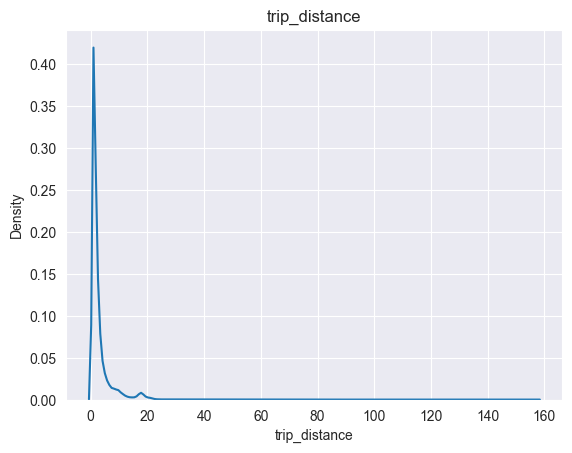


 mu = 2.93 and sigma = 3.80



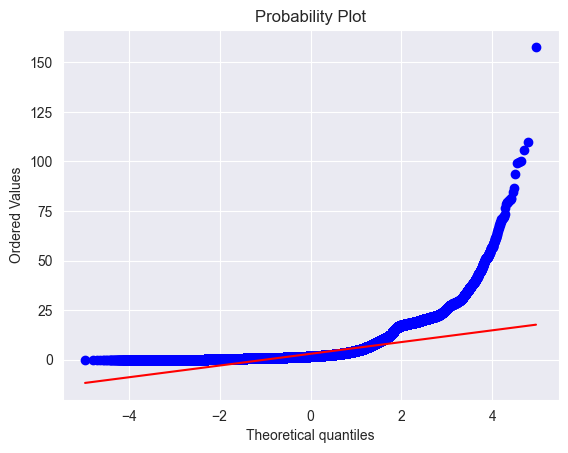

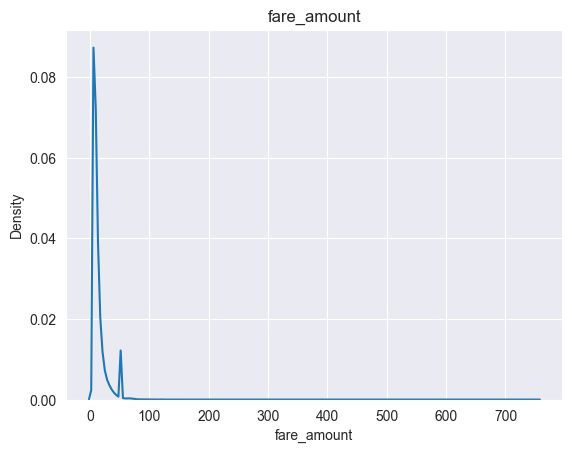


 mu = 13.42 and sigma = 11.96



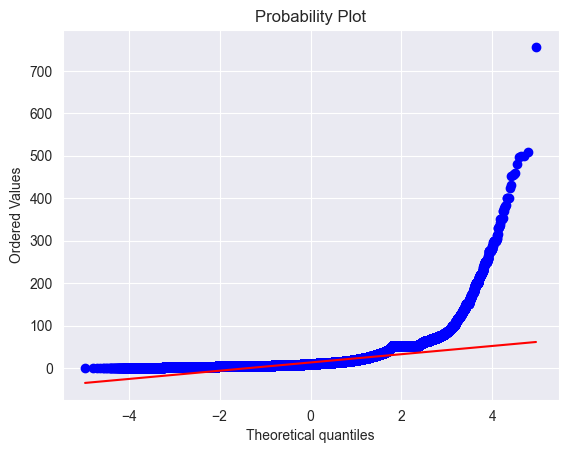

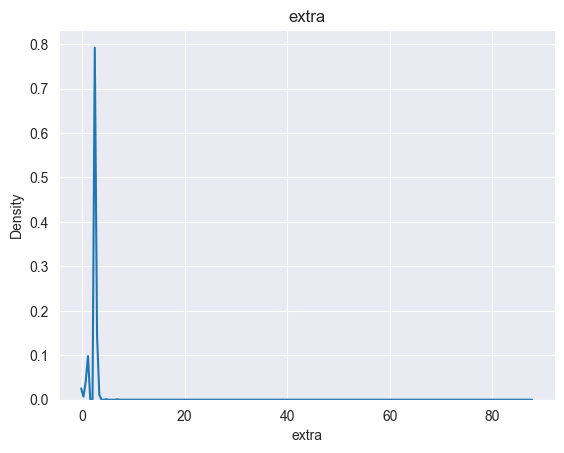


 mu = 1.08 and sigma = 1.25



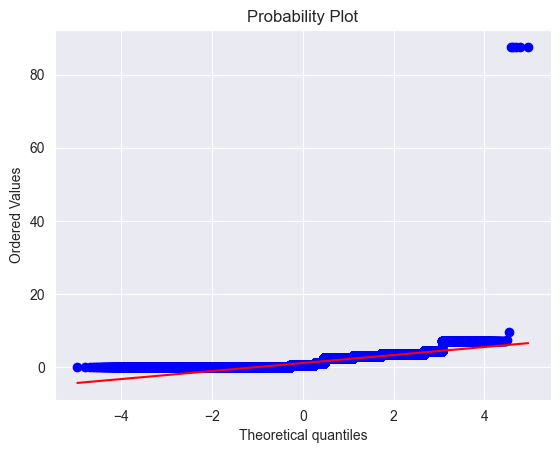

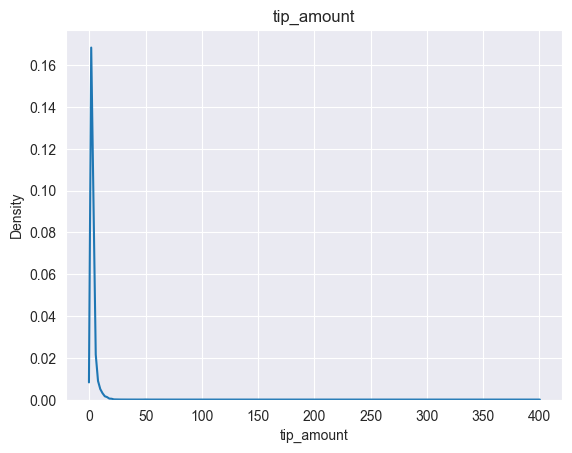


 mu = 2.30 and sigma = 2.86



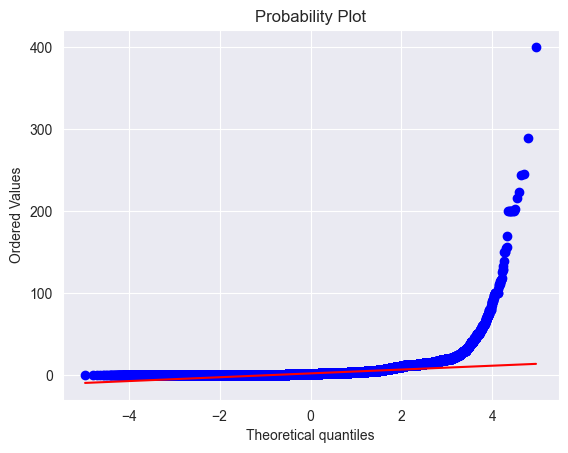

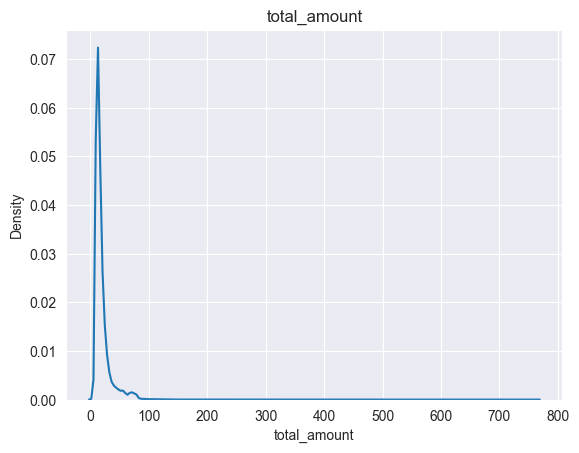


 mu = 19.50 and sigma = 14.77



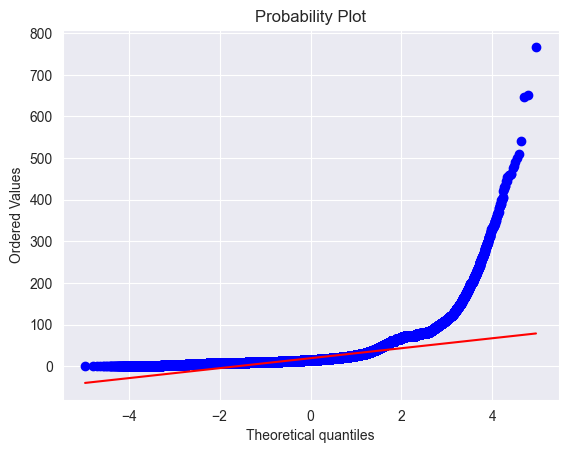

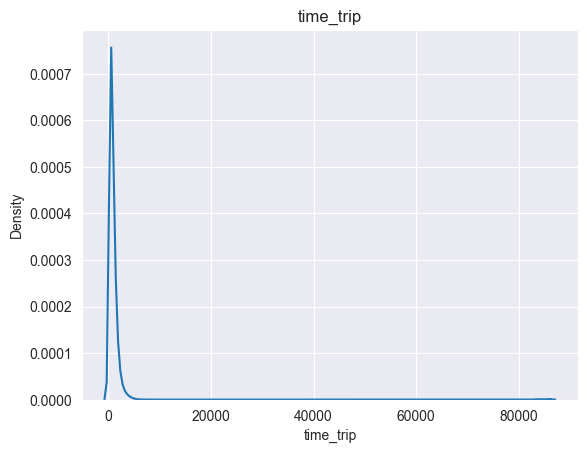


 mu = 1146.13 and sigma = 4570.05



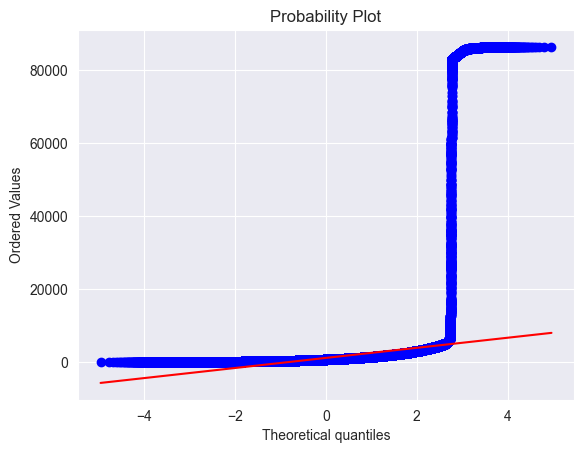

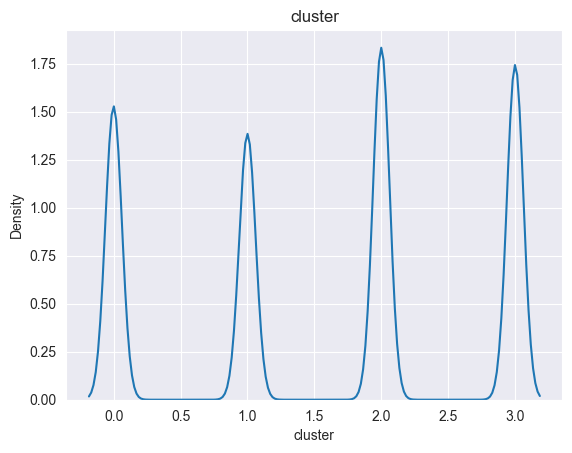


 mu = 1.58 and sigma = 1.12



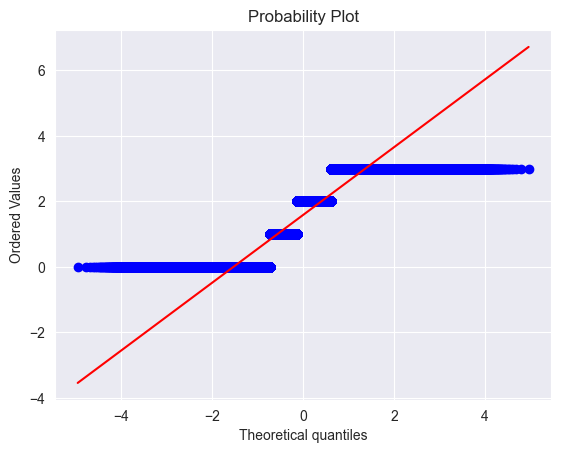

In [226]:
for column in df_2019.columns:
    sns.kdeplot(x=column, data=df_2019, common_norm=False)
    plt.title(column)
    plt.show()
    
    (mu, sigma) = norm.fit(df_2019[column])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.show()
    fig = plt.figure()
    res = stats.probplot(df_2019[column], plot=plt)
    plt.show()

Графики каждого атрибута распределены нормально 

In [221]:
df_2019.drop("cluster", axis=1).to_csv("data_2019_update.csv", index=False)
df_2020.to_csv("data_2020_update.csv", index=False)
df_2021.to_csv("data_2021_update.csv", index=False)

## Определите количество записей в каждом наборе (по годам), удовлетворяющих следующим требованиям


In [231]:
def update_df_for_task(df, year):
    df = df.drop("Unnamed: 0", axis=1)
    df = work_with_proportion(df, year)
    df["time_trip"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).apply(lambda x: x.total_seconds())
    df = df.drop(["tpep_dropoff_datetime","tpep_pickup_datetime"], axis=1)
    df = df.drop("store_and_fwd_flag",axis=1)
    
    columns_for_drop = ["VendorID",  "mta_tax", "congestion_surcharge", "payment_type", "improvement_surcharge","tolls_amount"]
    df = df.drop(columns_for_drop, axis=1)
    
    columns_for_under_zero = ['trip_distance', 'fare_amount', 'extra', 'tip_amount',
       'total_amount', 'time_trip', "PULocationID", "DOLocationID","RatecodeID", "passenger_count"]
    for column in columns_for_under_zero:
        was_lines = len(df)
        df = df[df[column] >= 0]
        print("Убрано отрицательных строк у колонки",column , " : ", was_lines - len(df))
    return df

In [232]:
df_2019_for_tasks = update_df_for_task(pd.read_csv("data_for_wr2019.csv"), 2019)
df_2020_for_tasks = update_df_for_task(pd.read_csv("data_for_wr2020.csv"), 2020)
df_2021_for_tasks = update_df_for_task(pd.read_csv("data_for_wr2021.csv"), 2021)

Убрано отрицательных строк у колонки trip_distance  :  0
Убрано отрицательных строк у колонки fare_amount  :  5340
Убрано отрицательных строк у колонки extra  :  2
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  0
Убрано отрицательных строк у колонки time_trip  :  972
Убрано отрицательных строк у колонки PULocationID  :  0
Убрано отрицательных строк у колонки DOLocationID  :  0
Убрано отрицательных строк у колонки RatecodeID  :  0
Убрано отрицательных строк у колонки passenger_count  :  0
Убрано отрицательных строк у колонки trip_distance  :  13
Убрано отрицательных строк у колонки fare_amount  :  6309
Убрано отрицательных строк у колонки extra  :  0
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  2
Убрано отрицательных строк у колонки time_trip  :  1
Убрано отрицательных строк у колонки PULocationID  :  0
Убрано отрицательных строк у колонки DOLocationID  :  0
Убрано

/var/folders/gl/gpj9t_b5575czff753kz6yb40000gn/T/ipykernel_73133/895508787.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2021_for_tasks = update_df_for_task(pd.read_csv("data_for_wr2021.csv"), 2021)


Убрано отрицательных строк у колонки trip_distance  :  0
Убрано отрицательных строк у колонки fare_amount  :  9926
Убрано отрицательных строк у колонки extra  :  0
Убрано отрицательных строк у колонки tip_amount  :  0
Убрано отрицательных строк у колонки total_amount  :  0
Убрано отрицательных строк у колонки time_trip  :  1
Убрано отрицательных строк у колонки PULocationID  :  0
Убрано отрицательных строк у колонки DOLocationID  :  0
Убрано отрицательных строк у колонки RatecodeID  :  15
Убрано отрицательных строк у колонки passenger_count  :  0


Районы, из которых чаще всего производилась посадка пассажиров,где чаевых было оставлено не менее 15% от суммы оплаты за поездку (длина поездки не должна превышать 2 км);

In [256]:
def task_1(df):
    print((((df.where((df["tip_amount"] / df["total_amount"]) >= 0,15)).where(df["trip_distance"] <= 2)).dropna()).groupby("PULocationID")["DOLocationID"].count().reset_index().rename({"DOLocationID":"count_trips"}, axis=1).sort_values(by='count_trips', ascending=False).head())


In [257]:
task_1(df_2019_for_tasks)

     PULocationID  count_trips
219         237.0        70929
218         236.0        58358
147         161.0        53191
170         186.0        45352
148         162.0        45209


In [258]:
task_1(df_2020_for_tasks)

     PULocationID  count_trips
218         237.0        70191
217         236.0        61195
147         161.0        55905
170         186.0        47080
148         162.0        46307


In [259]:
task_1(df_2021_for_tasks)

     PULocationID  count_trips
224         237.0        80719
223         236.0        78054
132         141.0        45579
226         239.0        42638
152         161.0        41865


Можно увидеть, что главные локации в топе, с каждым годом растут по популярности в высадке по условию 

Стоимость на километр поездки не превышала среднюю стоимость всех поездок на километр по такому же тарифу;


In [287]:
def drop_ratecode(df):
    return df.drop(df[df["RatecodeID"] > 6].index)

In [288]:
df_2019_for_tasks = drop_ratecode(df_2019_for_tasks)
df_2020_for_tasks = drop_ratecode(df_2020_for_tasks)
df_2021_for_tasks = drop_ratecode(df_2021_for_tasks)


In [360]:
def task_2(df): 
    df = df.drop(df[df["trip_distance"] == 0].index)
    df["money_per_km"] = df["total_amount"] / df["trip_distance"]
    for n in range(1,7):
        print(f"В тарифе {n} кол-во не привышающих среднюю стоимость",list((df[df["RatecodeID"] == n]).where(df["money_per_km"] <= df.groupby("RatecodeID")["money_per_km"].mean()[n]).dropna().groupby("RatecodeID")["trip_distance"].count())[0])

In [361]:
task_2(df_2019_for_tasks.copy())

В тарифе 1 кол-во не привышающих среднюю стоимость 1204464
В тарифе 2 кол-во не привышающих среднюю стоимость 48178
В тарифе 3 кол-во не привышающих среднюю стоимость 4476
В тарифе 4 кол-во не привышающих среднюю стоимость 976
В тарифе 5 кол-во не привышающих среднюю стоимость 4673
В тарифе 6 кол-во не привышающих среднюю стоимость 6


In [362]:
task_2(df_2020_for_tasks.copy())


В тарифе 1 кол-во не привышающих среднюю стоимость 1196729
В тарифе 2 кол-во не привышающих среднюю стоимость 50877
В тарифе 3 кол-во не привышающих среднюю стоимость 4179
В тарифе 4 кол-во не привышающих среднюю стоимость 1189
В тарифе 5 кол-во не привышающих среднюю стоимость 4715
В тарифе 6 кол-во не привышающих среднюю стоимость 5


In [363]:
task_2(df_2021_for_tasks.copy())


В тарифе 1 кол-во не привышающих среднюю стоимость 1193668
В тарифе 2 кол-во не привышающих среднюю стоимость 17670
В тарифе 3 кол-во не привышающих среднюю стоимость 1067
В тарифе 4 кол-во не привышающих среднюю стоимость 1015
В тарифе 5 кол-во не привышающих среднюю стоимость 2658
В тарифе 6 кол-во не привышающих среднюю стоимость 2


Среднее количество пассажиров на поездку, пользующихся услугами такси с самыми популярными тарифами.


In [320]:
def task_3(df):
    dd = pd.DataFrame(df.groupby("RatecodeID")["passenger_count"].count().reset_index()).rename({"passenger_count":"Popularity"}, axis=1)
    dd.insert(1, 'passenger_count_mean', list(df.groupby("RatecodeID")["passenger_count"].mean()))
    print(dd)

In [321]:
task_3(df_2019_for_tasks)

   RatecodeID  passenger_count_mean  Popularity
0           1              1.548060     1913359
1           2              1.584823       49916
2           3              1.631510        4608
3           4              1.509876        1367
4           5              1.458663        5564
5           6              0.875000           8


In [322]:
task_3(df_2020_for_tasks)

   RatecodeID  passenger_count_mean  Popularity
0         1.0              1.536614     1916376
1         2.0              1.640970       54781
2         3.0              1.695643        4544
3         4.0              1.552439        1640
4         5.0              1.550552       11770
5         6.0              0.947368          19


In [323]:
task_3(df_2021_for_tasks)

   RatecodeID  passenger_count_mean  Popularity
0         1.0              1.406091     1862439
1         2.0              1.486674       19286
2         3.0              1.546099        1269
3         4.0              1.424422        1687
4         5.0              1.229506        7002
5         6.0              1.538462          13


Популярность последнего года упала по отношению к предыдущим и количество людей уменьшилось на всех тарифах, кроме последнего тарифа